In [ ]:
!wget --no-check-certificate https://download.pytorch.org/tutorial/hymenoptera_data.zip

import zipfile
zip_file = 'hymenoptera_data.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('./data')
zip_ref.close()
!rm hymenoptera_data.zip

--2025-09-06 11:52:47--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.10.36, 18.160.10.22, 18.160.10.76, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.10.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  97.5MB/s    in 0.5s    

2025-09-06 11:52:47 (97.5 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

In [ ]:
CFG = { 'IMG_SIZE':64, 'EPOCHS':10,'LEARNING_RATE':3e-4, #3e-5
       'BATCH_SIZE': 128, 'SEED':55 }
device = torch.device('cuda') if torch.cuda.is_available() \
         else torch.device('cpu')

data_dir = 'data/hymenoptera_data'

In [ ]:
all_img_list = glob.glob('/content/data/hymenoptera_data/train/*/*')
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split('/')[5])
from collections import Counter
print(Counter(df['label']))
train = df

ll_img_list = glob.glob('/content/data/hymenoptera_data/test/*/*')
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split('/')[5])
from collections import Counter
print(Counter(df['label']))
test = df

Counter({'ants': 124, 'bees': 121})
Counter({'ants': 124, 'bees': 121})


In [ ]:
train_transform = A.Compose([A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406),
                                        std=(0.229, 0.224, 0.225),
                                        max_pixel_value=255.0,p=1.0),
                            ToTensorV2()])

test_transform = A.Compose([A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406),
                                        std=(0.229, 0.224, 0.225),
                                        max_pixel_value=255.0,p=1.0),
                            ToTensorV2()])

In [ ]:
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'])
test['label'] = le.transform(test['label'])
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
    def __len__(self):
        return len(self.img_path_list)

In [ ]:
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, \
                              train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], \
                          shuffle=True, num_workers=0)

test_dataset = CustomDataset(test['img_path'].values, test['label'].values, \
                              test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], \
                          shuffle=True, num_workers=0)

val_loader = test_loader

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=len(le.classes_)):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_b0(pretrained=True)
        #self.backbone = models.resnet101(pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    best_score = 0
    best_model = None
    for epoch in range(1, CFG['EPOCHS']+6):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(imgs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss: [{_train_loss:.5f}] \
        Val Loss: [{_val_loss:.5f}] Val Weighted F1 Score: [{_val_score:.5f}]')
        if scheduler is not None:
            scheduler.step(_val_score)
        if best_score < _val_score:
            best_score = _val_score
            best_model = model
    return best_model

def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)

            output = model(imgs)
            loss = criterion(output, labels)
            val_loss.append(loss.item())

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(torch.argmax(output, dim=1).cpu().numpy())

    _val_loss = np.mean(val_loss)
    _val_score = f1_score(all_labels, all_preds, average='weighted')

    return _val_loss, _val_score

In [ ]:
model = BaseModel()
for param in model.backbone.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), \
                             lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', \
        factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8)
infer_model = train(model, optimizer, train_loader, test_loader, scheduler, \
                    device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1], Train Loss: [0.91098]         Val Loss: [0.83301] Val Weighted F1 Score: [0.53639]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2], Train Loss: [0.95794]         Val Loss: [0.81189] Val Weighted F1 Score: [0.56838]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3], Train Loss: [0.87809]         Val Loss: [0.79947] Val Weighted F1 Score: [0.56842]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4], Train Loss: [0.78809]         Val Loss: [0.75113] Val Weighted F1 Score: [0.59061]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5], Train Loss: [0.76392]         Val Loss: [0.71389] Val Weighted F1 Score: [0.62415]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6], Train Loss: [0.69989]         Val Loss: [0.67268] Val Weighted F1 Score: [0.62855]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7], Train Loss: [0.70434]         Val Loss: [0.63722] Val Weighted F1 Score: [0.67756]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8], Train Loss: [0.71380]         Val Loss: [0.60562] Val Weighted F1 Score: [0.69379]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9], Train Loss: [0.71350]         Val Loss: [0.57581] Val Weighted F1 Score: [0.69752]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10], Train Loss: [0.71927]         Val Loss: [0.55262] Val Weighted F1 Score: [0.72232]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11], Train Loss: [0.62689]         Val Loss: [0.52819] Val Weighted F1 Score: [0.74682]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12], Train Loss: [0.60617]         Val Loss: [0.51016] Val Weighted F1 Score: [0.77139]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13], Train Loss: [0.57611]         Val Loss: [0.49134] Val Weighted F1 Score: [0.76315]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14], Train Loss: [0.60522]         Val Loss: [0.48071] Val Weighted F1 Score: [0.77132]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15], Train Loss: [0.59219]         Val Loss: [0.46100] Val Weighted F1 Score: [0.78328]


In [ ]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    lb =[]
    with torch.no_grad():
        for imgs, labels in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            pred = model(imgs)
            pred = np.array(pred.cpu())
            preds = np.append(preds, np.argmax(pred,axis=1))
            lb = np.append(lb, labels)
    return preds, lb

preds = inference(infer_model, test_loader, device)

  0%|          | 0/2 [00:00<?, ?it/s]

1.0
[[124   0]
 [  0 121]]


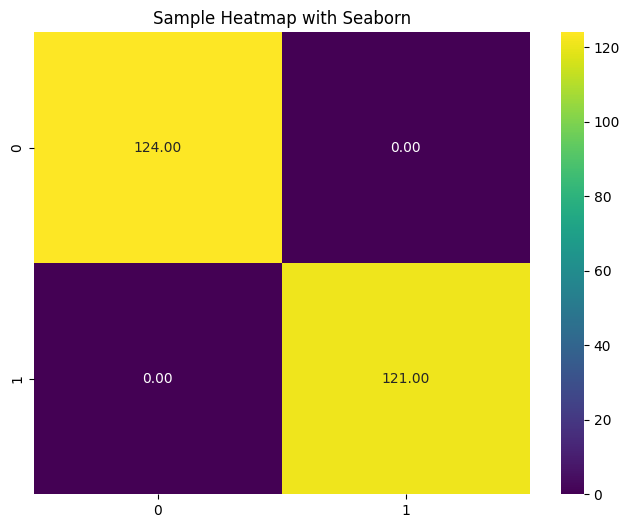

In [ ]:
print(np.mean(preds[0] == preds[1]))
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(preds[1], preds[0])
print(cm)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='viridis', fmt=".2f")
plt.title('Sample Heatmap with Seaborn')
plt.show()